In [134]:
import mne
import os
import re

# load data, I'm using NDARAA396TWZ and NDARAA773LUW as samples
resting_state_path = "sub-NDARAA396TWZ_task-RestingState_eeg.set"
contrast_change_path = "sub-NDARAA773LUW_task-contrastChangeDetection_run-1_eeg.set"

raw_data = []
raw_dir = os.path.join('..', '..', 'raw')
for file_name in [resting_state_path, contrast_change_path]:
    file_path = os.path.join(raw_dir, file_name)
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw_data.append(raw)

resting_state, contrast_change = raw_data
resting_state_sfreq = resting_state.info['sfreq']
contrast_change_sfreq = contrast_change.info['sfreq']

In [135]:
# data preparation
resting_state.filter(l_freq=1.0, h_freq=None)
contrast_change.filter(l_freq=1.0, h_freq=None)

# get first 3 seconds for consistency and ease of testing
resting_state_crop = resting_state.copy().crop(tmin=0, tmax=3)
contrast_change_crop = contrast_change.copy().crop(tmin=0, tmax=3)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 133 samples (0.266 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 133 samples (0.266 s)



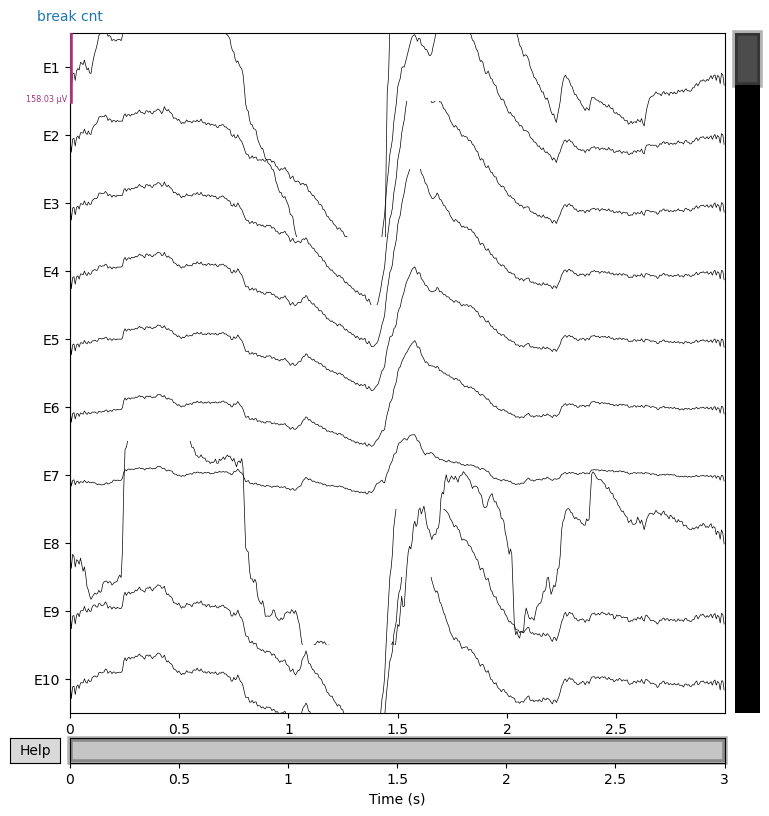

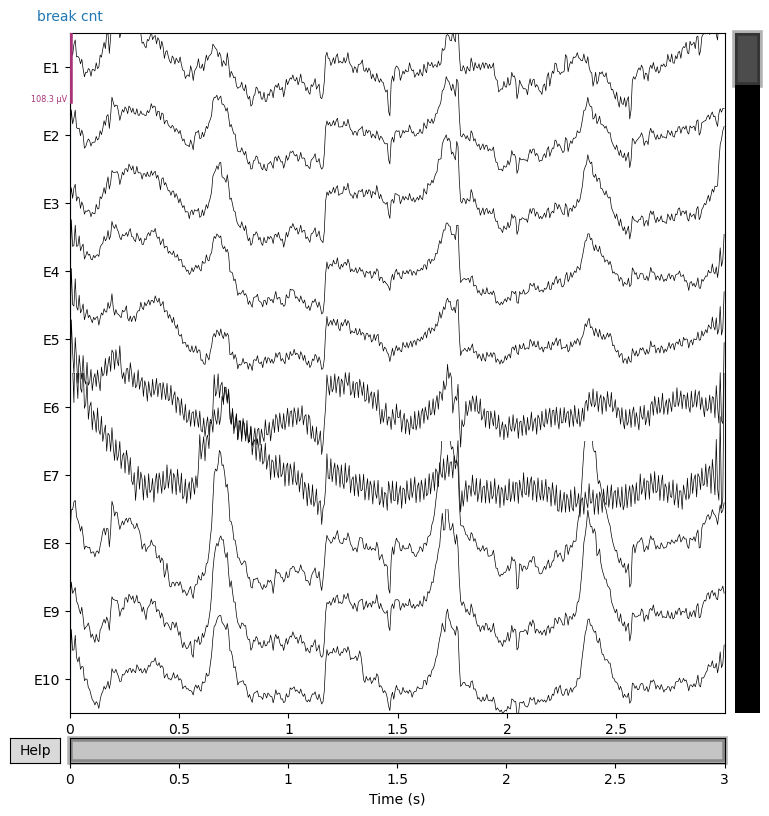

In [136]:
# low pass filter
h_freq = 50.0

low_pass_resting = resting_state_crop.copy().filter(l_freq=None, h_freq=h_freq)
low_pass_contrast = contrast_change_crop.copy().filter(l_freq=None, h_freq=h_freq)

p = low_pass_resting.plot(n_channels=10, scalings='auto', title='Low-pass Filtered Resting State', show=True, block=False)
p = low_pass_contrast.plot(n_channels=10, scalings='auto', title='Low-pass Filtered Contrast Change', show=True, block=False)

c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols


Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


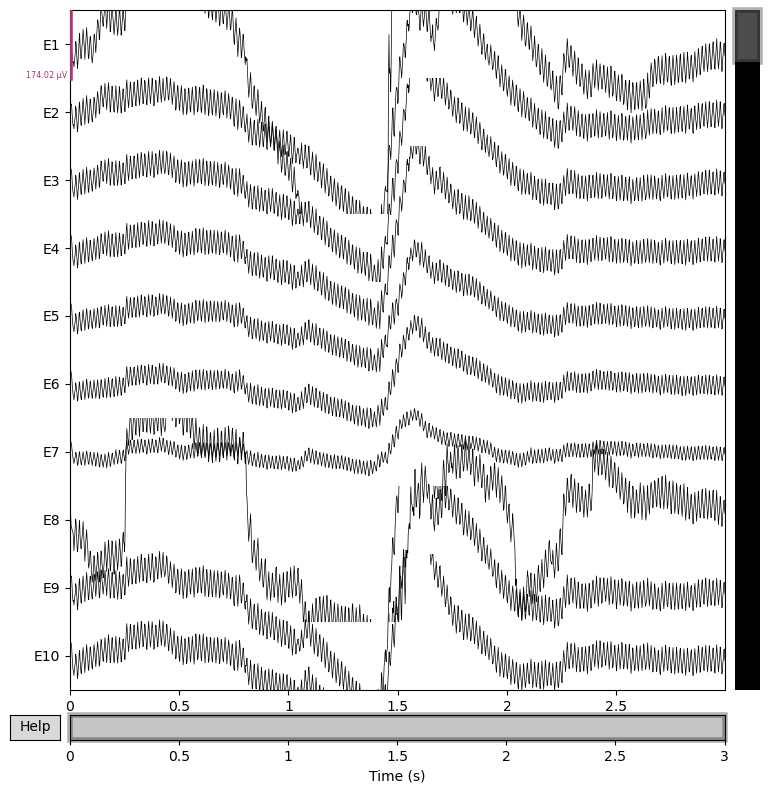

In [137]:
# Artifact Subspace Reconstruction (ASR)
# using ASRpy package
from asrpy import asr_calibrate, asr_process, ASR
import numpy as np

M, T = asr_calibrate(
    X=resting_state_crop.get_data().copy(),
    sfreq=resting_state_sfreq,
    cutoff=15
)

# using asr_process
asr_resting = asr_process(
    data=resting_state_crop.get_data().copy(),
    sfreq=resting_state_sfreq,
    M=M,
    T=T,
    lookahead=0.01,
)

asr_resting_raw = mne.io.RawArray(asr_resting, resting_state_crop.info)
asr_resting_raw.info['description'] = 'ASR processed resting state data'

p = asr_resting_raw.plot(n_channels=10, scalings='auto', title='ASR Processed Resting State', show=True, block=False)

c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols


Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


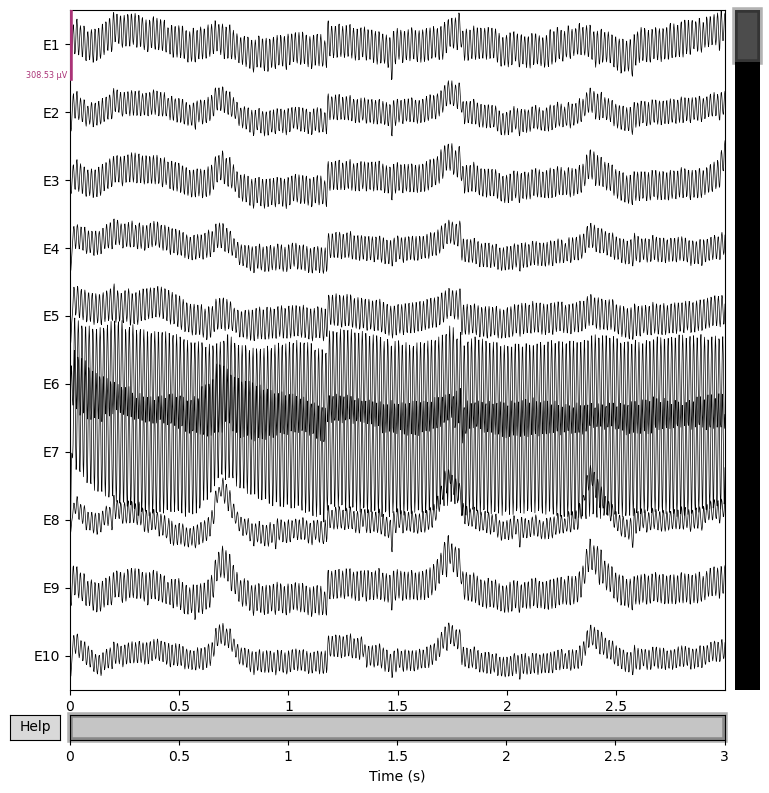

In [138]:
# repeat for contrast change data

M, T = asr_calibrate(
    X=contrast_change_crop.get_data().copy(),
    sfreq=resting_state_sfreq,
    cutoff=15
)

# using asr_process
asr_contrast = asr_process(
    data=contrast_change_crop.get_data().copy(),
    sfreq=resting_state_sfreq,
    M=M,
    T=T,
    lookahead=0.01,
)

asr_contrast_raw = mne.io.RawArray(asr_contrast, contrast_change_crop.info)
asr_contrast_raw.info['description'] = 'ASR processed contrast change data'

p = asr_contrast_raw.plot(n_channels=10, scalings='auto', title='ASR Processed Contrast Change', show=True, block=False)

Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr.py:750: RuntimeWarning: invalid value encountered in divide
  wz[ichan] = (Y - mu) / sig


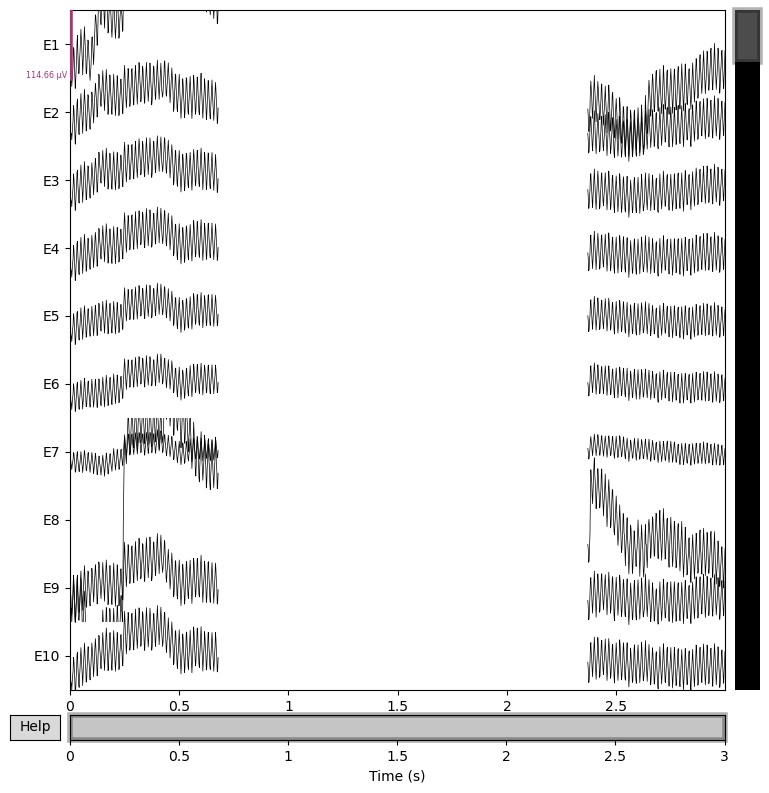

In [139]:
# clean windows (another cool tool asrpy offers)
from asrpy import clean_windows

resting_cleaned, mask = clean_windows(
    X=resting_state_crop.get_data(),
    sfreq=resting_state_sfreq
)

mask = mask.flatten()

resting_full = resting_state_crop.get_data().copy()
resting_full[:, ~mask] = np.nan

resting_cleaned_raw = mne.io.RawArray(resting_full, resting_state_crop.info)
resting_cleaned_raw.info['description'] = 'Cleaned windows resting state data'

p = resting_cleaned_raw.plot(n_channels=10, scalings='auto', title='Cleaned Windows Resting State', show=True, block=False)

Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr.py:750: RuntimeWarning: invalid value encountered in divide
  wz[ichan] = (Y - mu) / sig


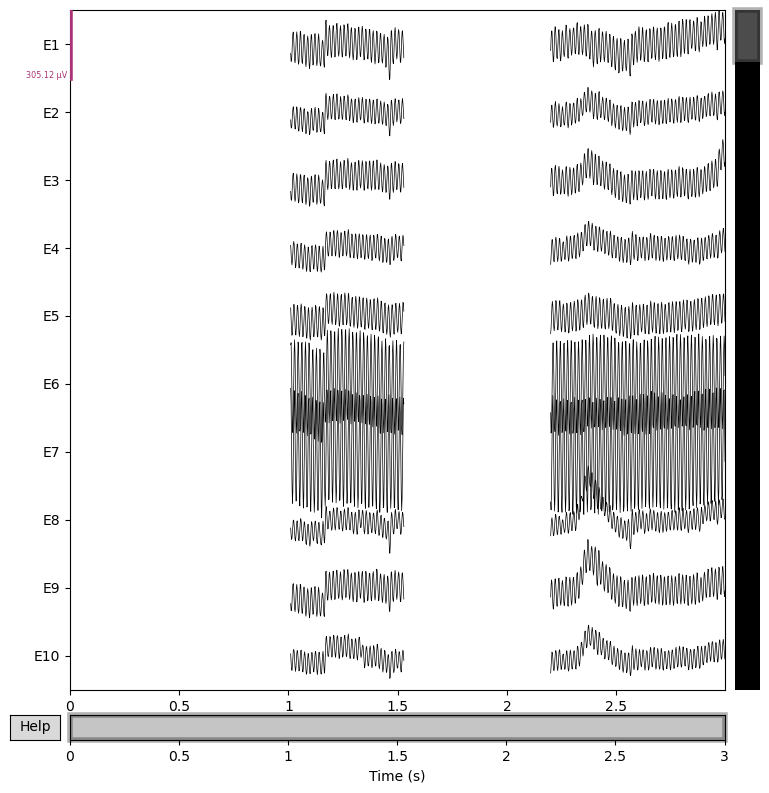

In [140]:
# repeat for contrast change data
contrast_cleaned, mask = clean_windows(
    X=contrast_change_crop.get_data(),
    sfreq=contrast_change_sfreq
)

mask = mask.flatten()

contrast_full = contrast_change_crop.get_data().copy()
contrast_full[:, ~mask] = np.nan

contrast_cleaned_raw = mne.io.RawArray(contrast_full, contrast_change_crop.info)
contrast_cleaned_raw.info['description'] = 'Cleaned windows contrast change data'

p = contrast_cleaned_raw.plot(n_channels=10, scalings='auto', title='Cleaned Windows Contrast Change', show=True, block=False)

Reducing nfft to 129
[PCA] Explained variance of selected components : 66.77%
Power of components removed by DSS: 0.39
Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


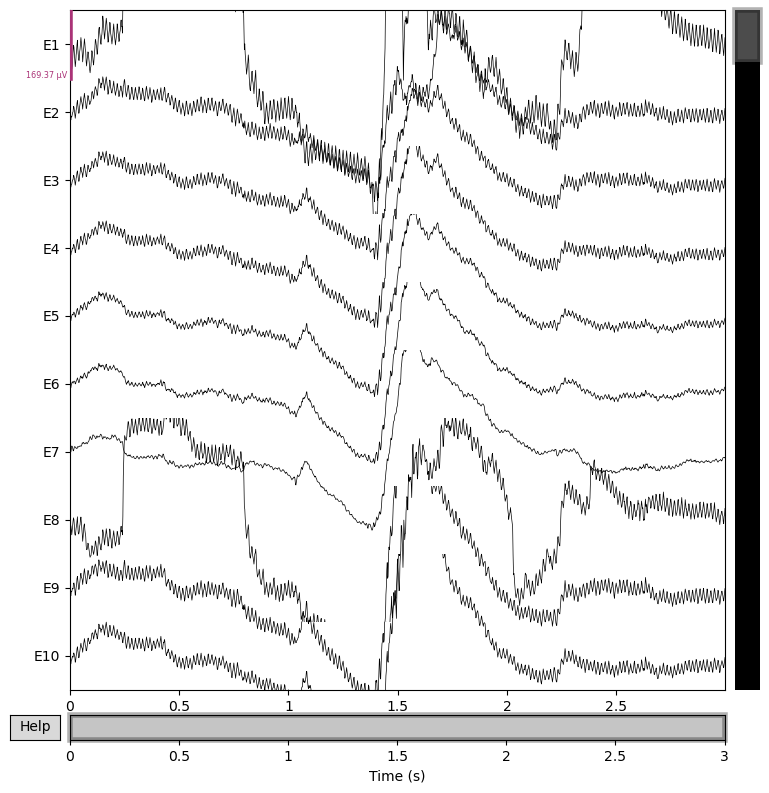

In [141]:
from meegkit import dss
# cleanline alternative

def zapline_clean(raw, fline):
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    out, _ = dss.dss_line(data, fline, sfreq=sfreq, nkeep=1)
    cleaned_raw = mne.io.RawArray(out, raw.info)
    return cleaned_raw

cleaned_resting_zapline = zapline_clean(resting_state_crop, fline=50.0)

p = cleaned_resting_zapline.plot(n_channels=10, scalings='auto', title='Zapline Cleaned Resting State', show=True, block=False)

Reducing nfft to 129
[PCA] Explained variance of selected components : 83.81%
Power of components removed by DSS: 0.73
Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


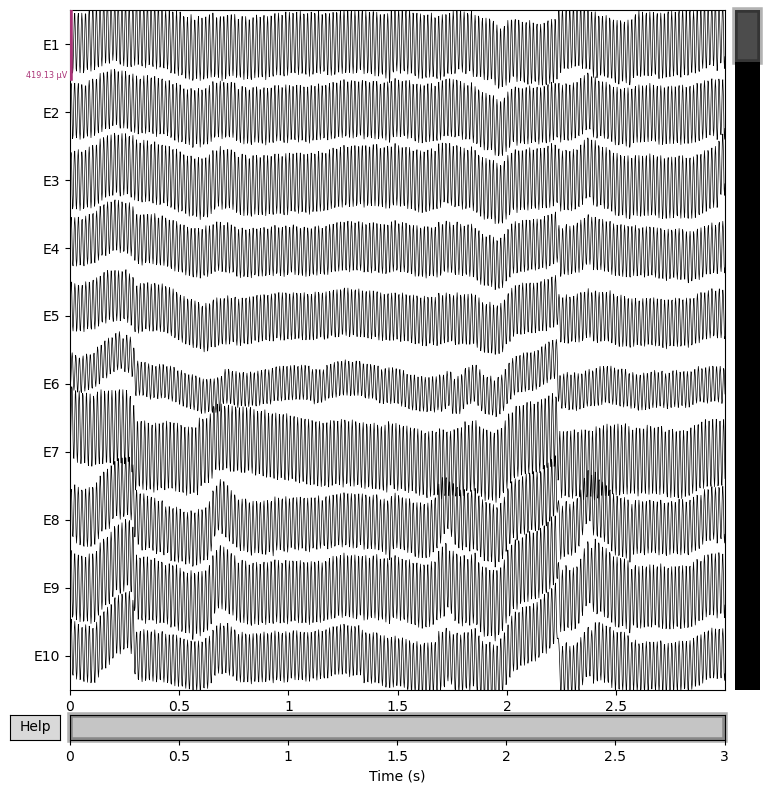

In [142]:
# do it for contrast change data
cleaned_contrast_zapline = zapline_clean(contrast_change_crop, fline=50.0)
p = cleaned_contrast_zapline.plot(n_channels=10, scalings='auto', title='Zapline Cleaned Contrast Change', show=True, block=False)

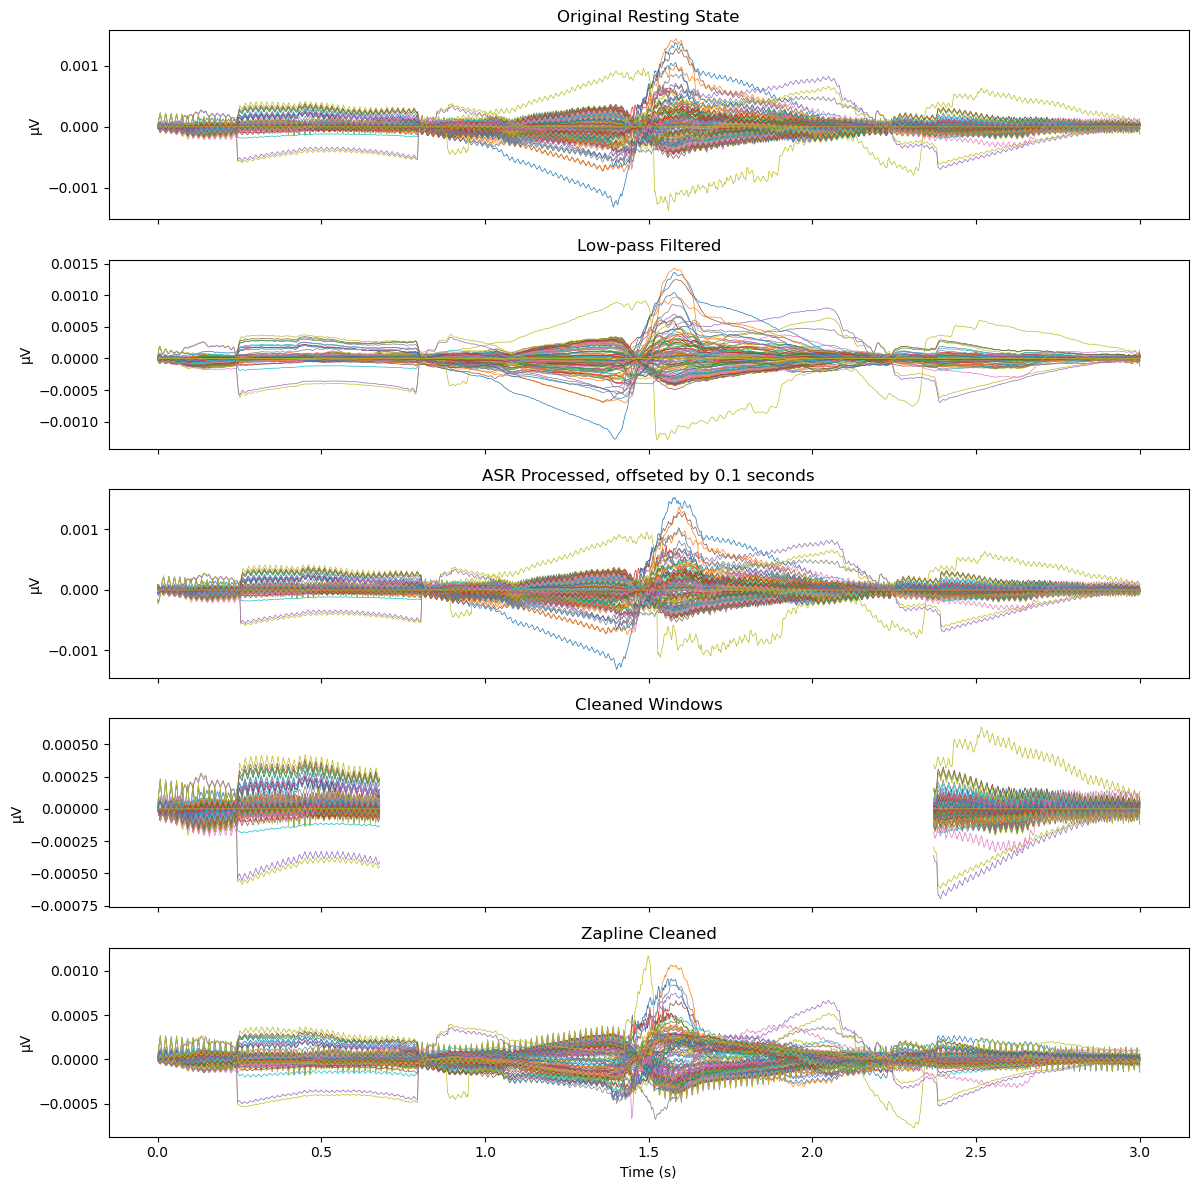

In [143]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

tmin, tmax = 0, 3
for ax, (raw, title) in zip(
    axes,
    [
        (resting_state_crop, "Original Resting State"),
        (low_pass_resting, "Low-pass Filtered"),
        (asr_resting_raw, "ASR Processed, offseted by 0.1 seconds"),
        (resting_cleaned_raw, "Cleaned Windows"),
        (cleaned_resting_zapline, "Zapline Cleaned")
    ],
):
    data, times = raw.copy().crop(tmin, tmax).get_data(return_times=True)
    ax.plot(times, data.T, lw=0.5)
    ax.set_title(title)
    ax.set_ylabel("µV")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

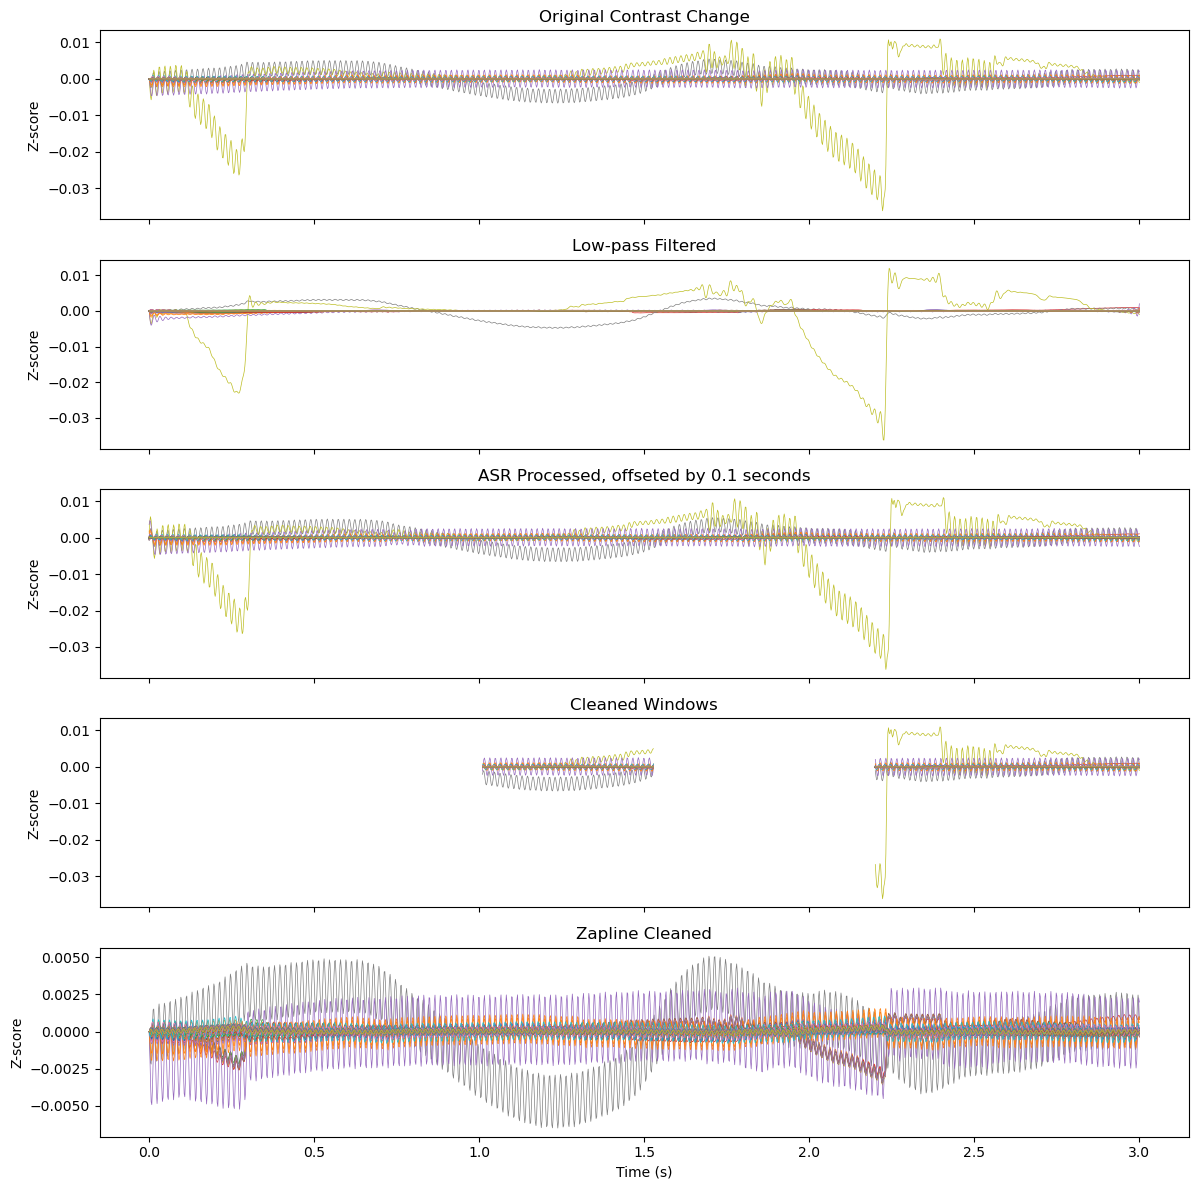

In [144]:
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

tmin, tmax = 0, 3
for ax, (raw, title) in zip(
    axes,
    [
        (contrast_change_crop, "Original Contrast Change"),
        (low_pass_contrast, "Low-pass Filtered"),
        (asr_contrast_raw, "ASR Processed, offseted by 0.1 seconds"),
        (contrast_cleaned_raw, "Cleaned Windows"),
        (cleaned_contrast_zapline, "Zapline Cleaned")
    ],
):
    data, times = raw.copy().crop(tmin, tmax).get_data(return_times=True)
    ax.plot(times, data.T, lw=0.5)
    ax.set_title(title)
    ax.set_ylabel("Z-score")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


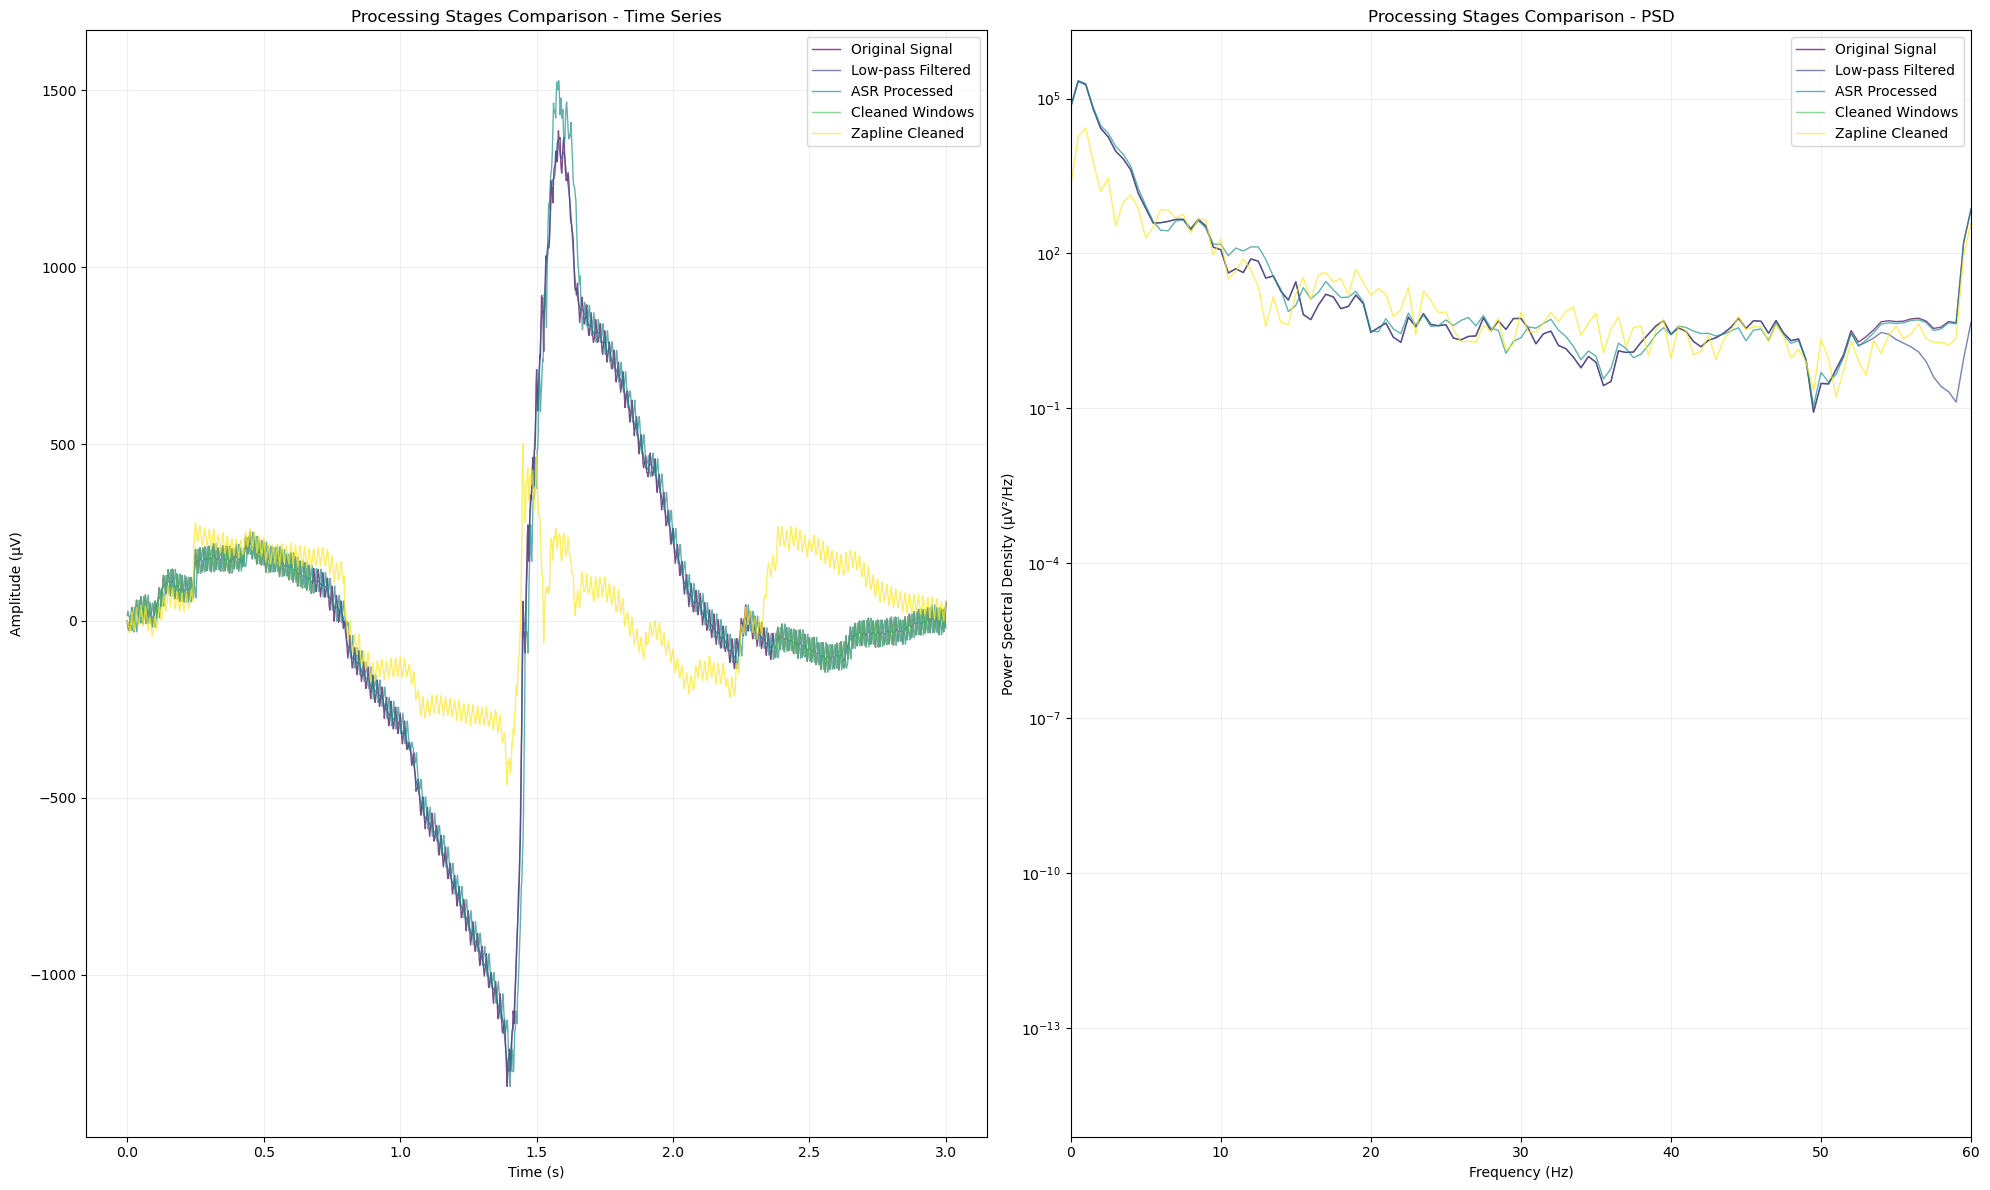


Original Signal:
Mean: 0.00, Std: 0.00

Low-pass Filtered:
Mean: 0.00, Std: 0.00

ASR Processed:
Mean: 0.00, Std: 0.00

Cleaned Windows:
Mean: nan, Std: nan

Zapline Cleaned:
Mean: 0.00, Std: 0.00


In [153]:
from asrpy import ASR
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Prepare data and ASR processing
raw = resting_state_crop.copy()
calib_data = raw.copy().pick_types(eeg=True)
asr = ASR(sfreq=resting_state_sfreq, cutoff=15)
asr.fit(calib_data)
cleaned_raw = asr.transform(raw)

# Create figure with time series and PSD side by side for each stage
fig, (ax_time, ax_psd) = plt.subplots(1, 2, figsize=(20, 12))

# Pick channels and prepare data
picks = mne.pick_types(raw.info, eeg=True)[:5]
times = raw.times
stages = [
    (resting_state_crop, "Original Signal"),
    (low_pass_resting, "Low-pass Filtered"),
    (asr_resting_raw, "ASR Processed"),
    (resting_cleaned_raw, "Cleaned Windows"),
    (cleaned_resting_zapline, "Zapline Cleaned")
]

colors = plt.cm.viridis(np.linspace(0, 1, len(stages)))

# Plot time series
for stage_idx, (stage_raw, title) in enumerate(stages):
    data = stage_raw.get_data(picks)[0] * 1e6  # Convert to µV
    ax_time.plot(times, data, color=colors[stage_idx], 
                 label=title, alpha=0.7, lw=1)
    
    # Calculate and plot PSD
    freqs, psd = signal.welch(data, raw.info['sfreq'],
                             nperseg=int(raw.info['sfreq']*2))
    ax_psd.semilogy(freqs, psd, color=colors[stage_idx],
                    label=title, alpha=0.7, lw=1)

# Time series plot settings
ax_time.set_xlabel('Time (s)')
ax_time.set_ylabel('Amplitude (µV)')
ax_time.set_title('Processing Stages Comparison - Time Series')
ax_time.legend(loc='upper right')
ax_time.grid(True, alpha=0.2)

# PSD plot settings
ax_psd.set_xlabel('Frequency (Hz)')
ax_psd.set_ylabel('Power Spectral Density (µV²/Hz)')
ax_psd.set_title('Processing Stages Comparison - PSD')
ax_psd.set_xlim(0, 60)
ax_psd.legend(loc='upper right')
ax_psd.grid(True, which='both', alpha=0.2)

plt.tight_layout()
plt.show()

# Print summary statistics
for stage_raw, title in stages:
    data = stage_raw.get_data(picks)[0]
    print(f"\n{title}:")
    print(f"Mean: {data.mean():.2f}, Std: {data.std():.2f}")

In [ ]:
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

def plot_processing_comparison(channel_indices, show_raw=True, show_lowpass=True, 
                             show_asr=True, show_clean=True, show_zapline=True):
    """Interactive plot of processing stages"""
    # Convert single index to list if needed
    if isinstance(channel_indices, int):
        channel_indices = [channel_indices]
    
    # Prepare stages based on selections
    stages = []
    if show_raw:
        stages.append((resting_state_crop, "Original Signal"))
    if show_lowpass:
        stages.append((low_pass_resting, "Low-pass Filtered"))
    if show_asr:
        stages.append((asr_resting_raw, "ASR Processed"))
    if show_clean:
        stages.append((resting_cleaned_raw, "Cleaned Windows"))
    if show_zapline:
        stages.append((cleaned_resting_zapline, "Zapline Cleaned"))
    
    # Create figure
    fig, (ax_time, ax_psd) = plt.subplots(1, 2, figsize=(20, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(stages)))
    
    # Plot each stage
    for stage_idx, (stage_raw, title) in enumerate(stages):
        for ch_idx in channel_indices:
            data = stage_raw.get_data([ch_idx])[0] * 1e6  # Convert to µV
            label = f"{title} - Ch {ch_idx}"
            
            # Time series
            ax_time.plot(stage_raw.times, data, 
                        color=colors[stage_idx], 
                        alpha=0.7, lw=1,
                        label=label)
            
            # PSD
            freqs, psd = signal.welch(data, stage_raw.info['sfreq'],
                                    nperseg=int(stage_raw.info['sfreq']*2))
            ax_psd.semilogy(freqs, psd, 
                           color=colors[stage_idx],
                           alpha=0.7, lw=1,
                           label=label)
    
    # Plot settings
    ax_time.set_xlabel('Time (s)')
    ax_time.set_ylabel('Amplitude (µV)')
    ax_time.set_title('Time Series Comparison')
    ax_time.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_time.grid(True, alpha=0.2)
    
    ax_psd.set_xlabel('Frequency (Hz)')
    ax_psd.set_ylabel('Power Spectral Density (µV²/Hz)')
    ax_psd.set_title('Power Spectral Density')
    ax_psd.set_xlim(0, 60)
    ax_psd.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_psd.grid(True, which='both', alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Create interactive widgets
channel_options = [(f"Channel {i}", i) for i in range(129)]
channel_select = widgets.SelectMultiple(
    options=channel_options,
    value=(0,),
    description='Channels:',
    disabled=False
)

# Create checkboxes for processing stages
stage_widgets = {
    'show_raw': widgets.Checkbox(value=True, description='Original'),
    'show_lowpass': widgets.Checkbox(value=True, description='Low-pass'),
    'show_asr': widgets.Checkbox(value=True, description='ASR'),
    'show_clean': widgets.Checkbox(value=True, description='Clean Windows'),
    'show_zapline': widgets.Checkbox(value=True, description='Zapline')
}

# Layout widgets
controls = widgets.VBox([
    widgets.HBox([channel_select]),
    widgets.HBox(list(stage_widgets.values()))
])

# Create interactive plot
interact(plot_processing_comparison, 
        channel_indices=channel_select,
        **stage_widgets)

interactive(children=(SelectMultiple(description='Channels:', index=(0,), options=(('Channel 0', 0), ('Channel…

<function __main__.plot_processing_comparison(channel_indices, show_raw=True, show_lowpass=True, show_asr=True, show_clean=True, show_zapline=True)>